This notebook takes raw data for 2011 - 2019, transforms it, creates feautures, and applies scaling.  
The resulting data is written into seperate folders for training, validation & testing in `processed_data_dir`.  
Data is measured at various locations. Here, only those locations where most metrics are available are selected.  
Data for each location is written to a seperate csv file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import datetime
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from src.directories import project_dir, raw_data_dir, interim_data_dir, processed_data_dir
from src.utils import SplitScaler
from src.visualization import plot_metrics

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [4]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# load meteo files and concat into one df
dfs = []

for file_ in [f'meteo-20{i}.csv' for i in range(11,20)]:
    print(f'Preparing {file_}...')
    df = pd.read_csv(raw_data_dir/file_, sep=';', encoding='latin-1')
    # scale down to hourly intervals by discarding :30 measures
    df = df[df.Zeitpunkt.str[14:] != '30']
    # change decimal from comma to period and make numeric
    df.HMW = df.HMW.str.replace(',','.')
    df.HMW = pd.to_numeric(df.HMW, errors='coerce')

    # 00:00 is encoded as 24:00
    # fix:
    # https://stackoverflow.com/questions/43359479/pandas-parsing-2400-instead-of-0000
    days = df.Zeitpunkt.str[:2]
    days.name = 'day'
    months = df.Zeitpunkt.str[3:5]
    months.name = 'month'
    years = df.Zeitpunkt.str[6:10]
    years.name = 'year'

    hours = df.Zeitpunkt.str[11:13]
    hours.name = 'hour'
    minutes = df.Zeitpunkt.str[14:]
    minutes.name = 'minute'

    times = pd.DataFrame()

    for i in [years, months, days, hours, minutes]:
        i = pd.to_numeric(i, errors='coerce')
        times = pd.concat([times, i], axis=1)
        
    df.Zeitpunkt = pd.to_datetime(times)

    # remove duplicates in index otherwhise unstacking won't work
    df.drop_duplicates(subset=['Messort', 'Parameter', 'Zeitpunkt'], inplace=True)

    # unstack index to get metrics into columns
    df.set_index(['Messort', 'Parameter', 'Zeitpunkt'], inplace=True)
    df = df.unstack('Parameter')
    # remove multilevel column names
    df.columns = df.columns.droplevel()
    df.columns.name = None
    
    dfs.append(df)

df = pd.concat(dfs)
# remove duplicates
df = df[~df.index.duplicated(keep='first')]
print('Done')

Preparing meteo-2011.csv...
Preparing meteo-2012.csv...
Preparing meteo-2013.csv...
Preparing meteo-2014.csv...
Preparing meteo-2015.csv...
Preparing meteo-2016.csv...
Preparing meteo-2017.csv...
Preparing meteo-2018.csv...
Preparing meteo-2019.csv...
Done


In [6]:
# coalesce Sonnenscheindauer into one column
df['Sonnenscheindauer [min]'] = df['Sonnenscheindauer [min]']\
                                 .combine_first(df['Sonnenscheindauer(min) [min]'])

df.drop('Sonnenscheindauer(min) [min]', axis=1, inplace=True)

In [7]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1893313 entries, ('Bergheim Siggerwiesen', Timestamp('2011-01-01 01:00:00')) to ('Zell am See - Eishalle', Timestamp('2020-01-01 00:00:00'))
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Luftdruck [hPa]            619146 non-null   float64
 1   Lufttemperatur [GradC]     1693362 non-null  float64
 2   Parameter                  0 non-null        float64
 3   Windgeschwindigkeit [m/s]  1358932 non-null  float64
 4   Windrichtung  [Grad]       1343051 non-null  float64
 5   Windspitze [m/s]           1358890 non-null  float64
 6   rel. Luftfeuchte [%]       1618600 non-null  float64
 7   Sonnenscheindauer [min]    80956 non-null    float64
dtypes: float64(8)
memory usage: 127.2+ MB


In [8]:
df.to_pickle(interim_data_dir/'sbg-weather-unstacked.pkl')

# Select data

In [9]:
df = pd.read_pickle(interim_data_dir/'sbg-weather-unstacked.pkl')

In [10]:
# count available metrics per location
overall_counts = pd.DataFrame()

for location in df.index.get_level_values(0).unique():
    counts_per_loc = df.loc[location,:].notna().sum()
    counts_per_loc.name = location
    overall_counts = pd.concat([overall_counts, counts_per_loc], axis=1)

overall_counts = overall_counts.transpose()

In [11]:
overall_counts

,Luftdruck [hPa],Lufttemperatur [GradC],Parameter,Windgeschwindigkeit [m/s],Windrichtung [Grad],Windspitze [m/s],rel. Luftfeuchte [%],Sonnenscheindauer [min]
Bergheim Siggerwiesen,78215,78502,0,64225,63825,64221,56271,0
Gaisberg Zistel,0,78446,0,0,0,0,78808,0
Hallein EisenbahnbrÃ¼cke,0,26303,0,25652,25652,25652,26303,0
Hallein Winterstall,78740,78685,0,78574,78574,78573,78614,0
Hallein Winterstall mitte,0,24695,0,0,0,0,5024,0
Hallein Winterstall oben,0,26105,0,0,0,0,14816,0
Hallein Winterstall untern,0,25490,0,0,0,0,12093,0
Haunsberg,78427,78423,0,78417,78417,78417,75978,0
Messort,0,0,0,0,0,0,0,0
Salzburg Fernheizwerk Mitte,0,0,0,78599,77361,78596,0,0


In [12]:
# use only locations for which the majority of metrics is available
selected_metrics = ['Luftdruck [hPa]', 'Lufttemperatur [GradC]',
       'Windgeschwindigkeit [m/s]', 'Windrichtung  [Grad]', 'Windspitze [m/s]',
       'rel. Luftfeuchte [%]']

min_counts = overall_counts[selected_metrics].min(axis=1)
selected_locations = min_counts[min_counts>6.9e4].index
selected_locations

Index(['Hallein Winterstall', 'Haunsberg', 'Salzburg Lehener Park',
       'St.Johann - Bezirkshauptmannschaft', 'Tamsweg',
       'Zell am See - Eishalle'],
      dtype='object')

In [13]:
df = df.loc[selected_locations, selected_metrics]

# Fill nas

In [14]:
df = df.fillna(method='ffill')

# Feature engineering

In [15]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#feature_engineering

## Wind

In [16]:
wv = df.pop('Windgeschwindigkeit [m/s]')
max_wv = df.pop('Windspitze [m/s]')

# Convert to radians.
wd_rad = df.pop('Windrichtung  [Grad]')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-10.598385568657747, 9.79685510466092, -20.99368305732129, 13.531573739317082)

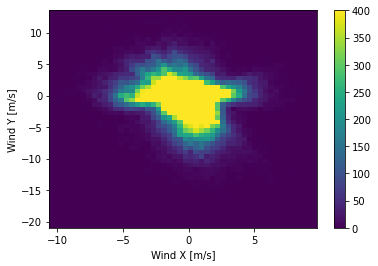

In [17]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

## Month and day as sine & cosine

In [18]:
datetimes = df.index.get_level_values(1)
#datetimes = datetimes.map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
timestamp_s = datetimes.map(datetime.datetime.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

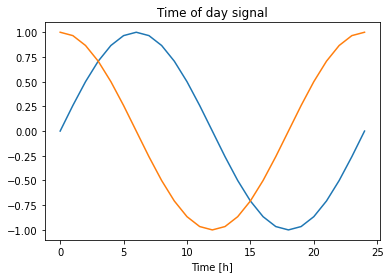

In [19]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [20]:
df.to_pickle(interim_data_dir/'sbg-weather.pkl')

# Visual Exploration

In [21]:
df = pd.read_pickle(interim_data_dir/'sbg-weather.pkl')

# parse date column & set multiindex
#df.Zeitpunkt = pd.to_datetime(df.Zeitpunkt, format='%Y-%m-%d %H:%M:%S')
#df.set_index(['Messort', 'Zeitpunkt'], inplace=True)

In [22]:
selected_locations

Index(['Hallein Winterstall', 'Haunsberg', 'Salzburg Lehener Park',
       'St.Johann - Bezirkshauptmannschaft', 'Tamsweg',
       'Zell am See - Eishalle'],
      dtype='object')

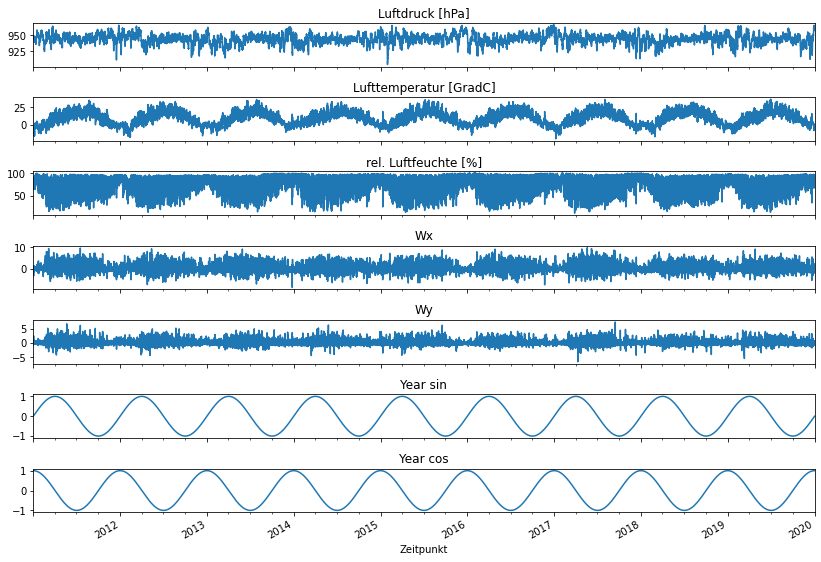

In [23]:
slc = slice('2011', None)
metrics = ['Luftdruck [hPa]', 'Lufttemperatur [GradC]', 'rel. Luftfeuchte [%]',
       'Wx', 'Wy', 'Year sin', 'Year cos']

plot_metrics(df.loc['St.Johann - Bezirkshauptmannschaft'], metrics=metrics, selected_slice=slc)

# Train test split & scaling

In [5]:
df = pd.read_pickle(interim_data_dir/'sbg-weather.pkl')

In [6]:
df.index.get_level_values(0).unique()

Index(['Hallein Winterstall', 'Haunsberg', 'Salzburg Lehener Park',
       'St.Johann - Bezirkshauptmannschaft', 'Tamsweg',
       'Zell am See - Eishalle'],
      dtype='object', name='Messort')

In [7]:
### encode locations as integers for embeddings
# get unique locations
locations_array = df.index.get_level_values(0)
unique_locations = locations_array.unique()
# assign an index to each location
locations_dict = {name: index for index, name in enumerate(unique_locations)}
# transform locations from index to integer representations
assign_location_int = lambda x: locations_dict[x]
locations = list(map(assign_location_int, locations_array))
locations = pd.Series(locations, index=df.index)

In [8]:
# set what ratio of the data should be used for
# training, validation & testing
train_share = 2/3
val_share = 2/9

train_val_ratios = (train_share,val_share)

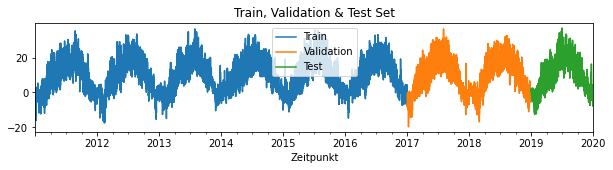

In [9]:
split_scaler = SplitScaler(df, train_val_ratios)
split_scaler.plot()

In [10]:
train_df = split_scaler.train
val_df = split_scaler.val
test_df = split_scaler.test

In [12]:
train_df.columns

Index(['Luftdruck [hPa]', 'Lufttemperatur [GradC]', 'rel. Luftfeuchte [%]',
       'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin',
       'Year cos'],
      dtype='object')

In [13]:
# assign unscaled location representations
# back to scaled dataframes
train_df['Location'] = locations.loc[pd.IndexSlice[:,split_scaler.train_slice]]
val_df['Location'] = locations.loc[pd.IndexSlice[:,split_scaler.val_slice]]
test_df['Location'] = locations.loc[pd.IndexSlice[:,split_scaler.test_slice]]

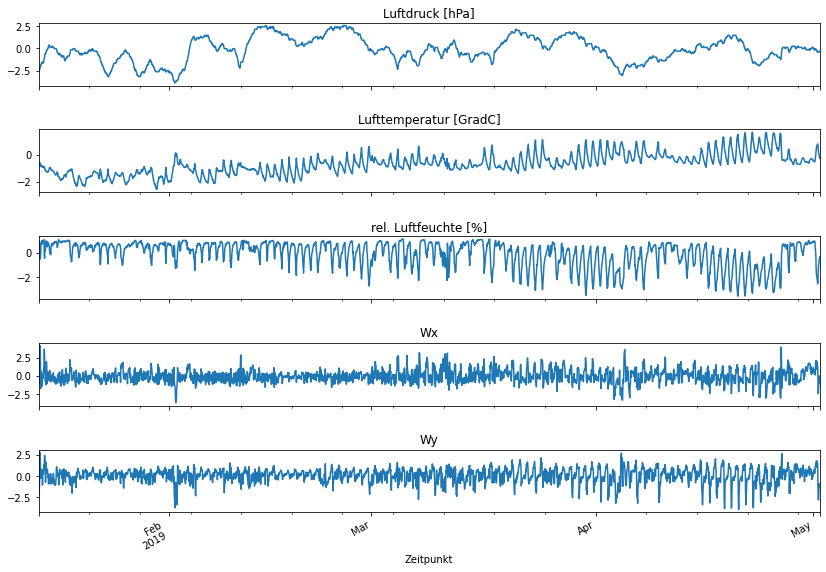

In [15]:
slc = slice('2019-01-14', '2019-05-01')
metrics = ['Luftdruck [hPa]', 'Lufttemperatur [GradC]', 'rel. Luftfeuchte [%]',
       'Wx', 'Wy']

plot_metrics(test_df.loc['Zell am See - Eishalle'], metrics=metrics, selected_slice=slc)

In [16]:
dstypes = ['train', 'val', 'test']
datasets = [train_df, val_df, test_df]

for dstype, dataset in zip(dstypes, datasets):
    # create seperate directories for training, 
    # validation & test data
    dstype_dir = processed_data_dir / dstype
    if not dstype_dir.exists():
        dstype_dir.mkdir()

    # write each location
    # to a seperate file
    for location in unique_locations:
        name = location.lower() \
            .replace('.', '') \
            .replace(' - ', '_') \
            .replace(' ', '_') 
        
        name += '.csv'

        dataset.loc[location].to_csv(dstype_dir/name,
            encoding='utf8', index=False)